In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import pickle
import skill_metrics as sm
from functools import reduce

In [2]:
#Load Data
greenbears = pd.read_csv('./data/phenology-2021-03-08-greenbears_stl.csv')
PEG = pd.read_csv('./data/preds.csv')
PEG_rfr = pd.read_csv('./data/prediction_0325_RFR.csv')
EDM = pd.read_csv('./data/phenology-2021-03-08-UCSC_P_EDM.csv')
Obs = pd.read_csv('https://data.ecoforecast.org/targets/phenology/phenology-targets.csv.gz')

In [3]:
site_names = Obs['siteID'].unique()
site_names

array(['HARV', 'BART', 'SCBI', 'STEI', 'UKFS', 'GRSM', 'DELA', 'CLBJ'],
      dtype=object)

In [4]:
#Define a funtion to extract mean for specific site. 
def extract_site_mean(data, target):
    if 'statistic' in data.columns:
        data = data[(data['siteID']==target) & (data['statistic']=='mean')]
    else:
        data = data[(data['siteID']==target)]
    data = data.set_index("time")
    return data

In [13]:
#Creat a dictionary to store taylor statistics
statistics = {}

#Loop to plot all Diagrams
for site in site_names:
    
    #Extract mean
    PEG_site = extract_site_mean(PEG, site)
    PEG_rfr_site = extract_site_mean(PEG_rfr, site)
    GB_site = extract_site_mean(greenbears, site)
    EDM_site = extract_site_mean(EDM, site)
    Obs_site = extract_site_mean(Obs, site).dropna()
    
    #Find similar date for all 
    similar_date = reduce(np.intersect1d, (Obs_site.index, PEG_site.index, PEG_rfr_site.index, GB_site.index, EDM_site.index))
    
    #Calculate statistics for taylor diagram
    PEG_taylor_stats = sm.taylor_statistics(PEG_site['gcc_90'][similar_date],Obs_site['gcc_90'][similar_date])
    PEG_rfr_taylor_stats = sm.taylor_statistics(PEG_rfr_site['gcc_90'][similar_date],Obs_site['gcc_90'][similar_date])
    GB_taylor_stats = sm.taylor_statistics(GB_site['gcc_90'][similar_date],Obs_site['gcc_90'][similar_date])
    EDM_taylor_stats = sm.taylor_statistics(EDM_site['gcc_90'][similar_date],Obs_site['gcc_90'][similar_date])
    Obs_taylor_stats = sm.taylor_statistics(Obs_site['gcc_90'][similar_date],Obs_site['gcc_90'][similar_date])
    
    #Store Statistics for each site
    statistics[site] = {'PEG_simple':PEG_taylor_stats,
                         'PEG_rfr': PEG_rfr_taylor_stats,
                         'GB': GB_taylor_stats,
                         'EDM': EDM_taylor_stats,
                         'Obs': Obs_taylor_stats}
    
    #Store statstics for Taylor Diagram for other teams/competitor
    sdev = np.array([PEG_taylor_stats['sdev'][0],
                GB_taylor_stats['sdev'][1], 
                EDM_taylor_stats['sdev'][1]])

    crmsd = np.array([PEG_taylor_stats['crmsd'][0], 
                GB_taylor_stats['crmsd'][1], 
                EDM_taylor_stats['crmsd'][1]])

    ccoef = np.array([PEG_taylor_stats['ccoef'][0],
                GB_taylor_stats['ccoef'][1], 
                EDM_taylor_stats['ccoef'][1]])
    
    #Set label for other teams. PEG will be added as a second layer later.
    label = ['Obs', 'GB', 'EDM']  

    #Draw Taylor Diagram for other teams 
    plt.title(label = "Site: " + str(site), fontsize=20, x=0.8, y=1.2)
    sm.taylor_diagram(sdev, crmsd, ccoef, numberPanels = 2,
                  markerLabel = label, markerLabelColor = 'r', markerSize = 9, 
                titleRMS = 'off', widthRMS = 0.7,
                titleSTD='on', showlabelsSTD='on', widthSTD = 0.8,
                #titleOBS = 'Obs', 
                  styleOBS = '-.', markerobs = 'o',
                colCOR = 'k', styleCOR = '--', widthCOR = 0.8)
    
    
    
    #Store statstics for Taylor Diagram for PEG
    sdev_PEG = np.array([PEG_taylor_stats['sdev'][0],
                PEG_taylor_stats['sdev'][1],
                PEG_rfr_taylor_stats['sdev'][1]])

    crmsd_PEG = np.array([PEG_taylor_stats['crmsd'][0], 
                PEG_taylor_stats['crmsd'][1],
                PEG_rfr_taylor_stats['crmsd'][1]])

    ccoef_PEG = np.array([PEG_taylor_stats['ccoef'][0],
                PEG_taylor_stats['ccoef'][1],
                PEG_rfr_taylor_stats['ccoef'][1]])
    
    #Set Label for PEG models 
    label = ['Non-Dimensional Observation', 'PEG', 'PEG_rfr']

    #Second layer for PEG. Comment in function: overlay = 'on'
    sm.taylor_diagram(sdev_PEG,crmsd_PEG,ccoef_PEG, overlay = 'on',  titleSTD='on',
                      markerLabel = label, markerLabelColor = 'b',
                      markerColor = 'b')
    
    
    #Uncomment following two lines if want to save 
    #plt.savefig('./Taylor_Diagrams/taylor_'+str(site)+'.png')
    #plt.close()
    
    plt.show()

In [6]:
#Examine the correctness of GRSM
PEG_GRSM = extract_site_mean(PEG, 'GRSM')
PEG_rfr_GRSM = extract_site_mean(PEG_rfr, 'GRSM')
Obs_GRSM = extract_site_mean(Obs, 'GRSM').dropna()

GRSM_whole = pd.concat([Obs_GRSM['gcc_90'], PEG_GRSM['gcc_90'], PEG_rfr_GRSM['gcc_90']], 
                       axis=1, 
                       join="inner")
GRSM_whole.columns = ['Obs', 'simple', 'rfr']

In [7]:
GRSM_whole

,Obs,simple,rfr
time,,,
2021-03-25,0.36235,0.348271,0.405620
2021-03-26,0.34947,0.350280,0.405786
2021-03-27,0.35608,0.351844,0.406007
2021-03-28,0.35602,0.350165,0.404313
2021-03-29,0.34864,0.348844,0.405275
2021-03-30,0.35131,0.349809,0.404941
2021-03-31,0.35812,0.351471,0.404740
2021-04-01,0.35531,0.352186,0.403935
2021-04-02,0.35342,0.352139,0.404240


array([[<AxesSubplot:xlabel='Obs', ylabel='Obs'>,
        <AxesSubplot:xlabel='simple', ylabel='Obs'>,
        <AxesSubplot:xlabel='rfr', ylabel='Obs'>],
       [<AxesSubplot:xlabel='Obs', ylabel='simple'>,
        <AxesSubplot:xlabel='simple', ylabel='simple'>,
        <AxesSubplot:xlabel='rfr', ylabel='simple'>],
       [<AxesSubplot:xlabel='Obs', ylabel='rfr'>,
        <AxesSubplot:xlabel='simple', ylabel='rfr'>,
        <AxesSubplot:xlabel='rfr', ylabel='rfr'>]], dtype=object)

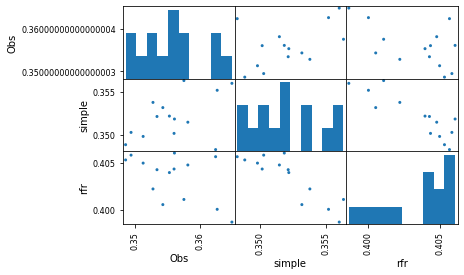

In [8]:
pd.plotting.scatter_matrix(GRSM_whole, alpha=1)

In [9]:
#Corr betwenn obs and rfr. Correct shown on taylor diagram. 
np.corrcoef(GRSM_whole.Obs, GRSM_whole.rfr)

array([[ 1.        , -0.52948027],
       [-0.52948027,  1.        ]])

In [10]:
#Corr betwenn obs and simple. Correct shown on taylor diagram. 
np.corrcoef(GRSM_whole.Obs, GRSM_whole.simple)

array([[1.        , 0.46404448],
       [0.46404448, 1.        ]])

In [11]:
#Call dictionay to see statistics
statistics['HARV']

{'PEG_simple': {'ccoef': array([1.        , 0.13144072]),
  'crmsd': [0.0, 0.0016279467494263345],
  'sdev': [0.0014846500309115686, 0.0008909206465734506]},
 'PEG_rfr': {'ccoef': array([ 1.        , -0.38325829]),
  'crmsd': [0.0, 0.0017934853249534143],
  'sdev': [0.0014846500309115686, 0.000586923737172592]},
 'GB': {'ccoef': array([1.        , 0.42325794]),
  'crmsd': [0.0, 0.0013698395631688168],
  'sdev': [0.0014846500309115686, 0.0008875203937089003]},
 'EDM': {'ccoef': array([1.        , 0.18798695]),
  'crmsd': [0.0, 0.0023635347924224046],
  'sdev': [0.0014846500309115686, 0.002139203677465014]},
 'Obs': {'ccoef': array([1., 1.]),
  'crmsd': [0.0, 0.0],
  'sdev': [0.0014846500309115686, 0.0014846500309115686]}}